# Linear regression with learnable noise parameter

In [138]:
try:
  import optax
except:
  %pip install -qq optax
  import optax
try:
    from ajax import ADVI
except:
   %pip install -qq git+https://github.com/patel-zeel/ajax.git
   from ajax import ADVI

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import train
import jax
from functools import partial
import matplotlib.pyplot as plt
import pickle
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
import seaborn as sns

In [139]:
url = "https://raw.githubusercontent.com/AnandShegde/pml_baselines/main/data/linear_regression/linear_regression"
data = pd.read_pickle(url)

X = data['data']['x']
Y = data['data']['y'] 
Y = jnp.array(data['data']['y']).reshape((-1))
prior_mean = data['prior']['mean']
prior_cov = data['prior']['var']
prior_alpha = data['prior']['alpha']
prior_beta = data['prior']['beta']

def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = X.shape[0]
X = identity_trans(X)

## Defining model in ajax

In [141]:
prior = {
    "theta" : tfd.MultivariateNormalDiag(loc = prior_mean, scale_diag = jnp.diagonal(prior_cov)),
    "noise" : tfd.InverseGamma(concentration = prior_alpha, scale = prior_beta)
}

bijectors = {
    "theta":tfb.Identity(),
    "noise":tfb.Exp()
}

def get_log_likelihood(params, aux, data, **kwargs):
    mean = aux["X"]@params["theta"]
    diag = jnp.ones_like(mean)*params["noise"]
    likelihood = tfd.MultivariateNormalDiag(loc  = mean, scale_diag = diag)
    return likelihood.log_prob(data).sum()

model = ADVI(prior, bijectors, get_log_likelihood, vi_type = "full_rank")

## Training model

Text(0, 0.5, 'loss')

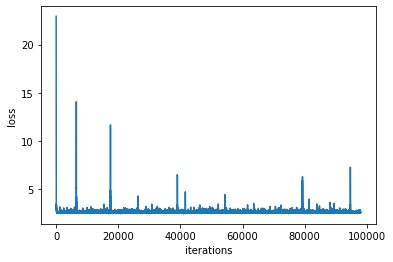

In [172]:
optimizer = optax.adam(learning_rate=0.1)
epochs = 98000
seed = jax.random.PRNGKey(10)
params = model.init(seed)

loss_fn = partial(model.loss_fn,batch = Y,  data_size = len(Y), aux = {"X":X}, n_samples = 10)
model_params = train(loss_fn, params, optimizer = optimizer, n_epochs = epochs, seed = jax.random.PRNGKey(100),return_args = ["losses"])

plt.plot(model_params["losses"])
plt.xlabel("iterations")
plt.ylabel("loss")

## Plotting results

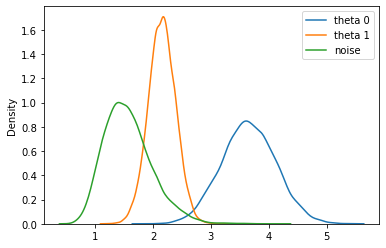

In [173]:
posterior = model.apply(model_params["params"])
samples = posterior.sample(seed = jax.random.PRNGKey(6), sample_shape = (10000,))
sns.kdeplot(samples['theta'][:,0],label = 'theta 0')
sns.kdeplot(samples['theta'][:,1],label = 'theta 1')
sns.kdeplot(samples['noise'],label = 'noise')
plt.legend()

In [174]:
with open ("../results/linear_regression_noise/results_data/ajax_model","wb") as f:
    pickle.dump(posterior,f,protocol=1)